### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [108]:
import scipy.stats as stats
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as sm
from sklearn.preprocessing import PowerTransformer, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [4]:
pd.options.display.max_columns = None

### Import Dataset

In [5]:
df = pd.read_csv('train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df.shape

(8693, 14)

In [7]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [176]:
test = pd.read_csv('test.csv')
test1 = test.copy()
test.shape, test.isna().sum()

((4277, 13),
 PassengerId       0
 HomePlanet       87
 CryoSleep        93
 Cabin           100
 Destination      92
 Age              91
 VIP              93
 RoomService      82
 FoodCourt       106
 ShoppingMall     98
 Spa             101
 VRDeck           80
 Name             94
 dtype: int64)

### Feature Engineering

In [9]:
df1 = df.copy()

In [10]:
x = df1.PassengerId.str[:4].value_counts()
df1['Group'] = df1.PassengerId.str[:4].map(x)

In [11]:
df1[['Deck', 'Cabin_Number', 'Side']] = df1.Cabin.str.split('/', expand=True)

In [177]:
x_test = test.PassengerId.str[:4].value_counts()
test['Group'] = test.PassengerId.str[:4].map(x_test)
test[['Deck', 'Cabin_Number', 'Side']] = test.Cabin.str.split('/', expand=True)

In [13]:
df1.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin_Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,F,1,S


### Missing Values

#### HomePlanet

In [14]:
df1.HomePlanet.value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [15]:
df1.loc[df.VIP == True, 'HomePlanet'].value_counts()

Europa    131
Mars       63
Name: HomePlanet, dtype: int64

In [16]:
df1.loc[df.VIP == True, 'Destination'].value_counts()

TRAPPIST-1e      114
55 Cancri e       65
PSO J318.5-22     18
Name: Destination, dtype: int64

In [17]:
df1.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [18]:
tab = pd.crosstab(df1.HomePlanet, df1.Destination)
tab

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,690,712,3101
Europa,886,19,1189
Mars,193,49,1475


In [19]:
stats.chi2_contingency(tab)

(1144.18502191443,
 2.0026455334311217e-246,
 4,
 array([[ 958.11967765,  422.46090931, 3122.41941304],
        [ 445.54799134,  196.45417368, 1451.99783498],
        [ 365.33233101,  161.08491701, 1190.58275198]]))

In [20]:
x = df.loc[df.HomePlanet.isna(), ['HomePlanet', 'Destination']].isna().sum(axis=1)
x[x > 1]

347     2
5208    2
5687    2
6629    2
dtype: int64

In [21]:
df1.loc[((df1.HomePlanet.isna()) & (df1.Destination == '55 Cancri e')), 'HomePlanet'] = 'Europa'
df1.HomePlanet.fillna('Earth', inplace=True)

In [22]:
df1.HomePlanet.isna().sum()

0

#### Cryosleep

In [23]:
df1.CryoSleep.value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [24]:
df1.loc[df.CryoSleep.isna(), 'Deck'].value_counts()

F    68
G    63
C    23
E    20
B    19
D    10
A     6
T     1
Name: Deck, dtype: int64

In [25]:
pd.crosstab(df1.Deck, df1.CryoSleep)

CryoSleep,False,True
Deck,,
A,182,68
B,341,419
C,430,294
D,364,104
E,688,168
F,2176,550
G,1146,1350
T,4,0


In [26]:
pd.crosstab(df1.Side, df1.CryoSleep)

CryoSleep,False,True
Side,,
P,2673,1420
S,2658,1533


In [27]:
df1.CryoSleep.fillna(False, inplace=True)

#### Destination

In [28]:
df1.Destination.value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [29]:
tab = pd.crosstab(df1.HomePlanet, df1.Destination)
tab

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,690,728,3251
Europa,917,19,1189
Mars,193,49,1475


In [30]:
df1.groupby('Destination')['Deck'].value_counts()

Destination    Deck
55 Cancri e    F        398
               G        365
               B        333
               C        317
               E        116
               D        113
               A        108
PSO J318.5-22  G        461
               F        241
               E         41
               D         17
               C         13
               B          3
               A          2
TRAPPIST-1e    F       2088
               G       1688
               E        696
               B        426
               C        405
               D        338
               A        142
               T          5
Name: Deck, dtype: int64

In [31]:
df1.Destination.fillna('TRAPPIST-1e', inplace=True)

In [32]:
df1.Destination.isna().sum()

0

#### Age

In [33]:
df1.Age.describe()

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

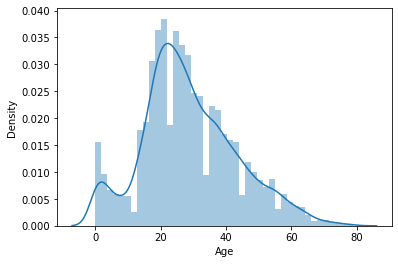

In [34]:
sns.distplot(df1.Age)
plt.show()

In [35]:
df1[df1.Age == 0].shape

(178, 18)

In [36]:
df1[df1.Age < 5]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin_Number,Side
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True,2,G,0,P
21,0020_01,Earth,True,E/0/S,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Almary Brantuarez,False,6,E,0,S
25,0020_05,Earth,True,E/0/S,PSO J318.5-22,1.0,False,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,False,6,E,0,S
34,0031_02,Mars,False,F/9/P,TRAPPIST-1e,2.0,False,0.0,0.0,0.0,0.0,0.0,Cinets Datie,True,3,F,9,P
44,0044_02,Earth,True,G/3/P,55 Cancri e,4.0,False,0.0,0.0,0.0,0.0,0.0,Kayne Coopelandez,True,3,G,3,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8649,9227_03,Earth,True,G/1498/P,PSO J318.5-22,1.0,False,0.0,0.0,0.0,0.0,0.0,Paulas Hinglendez,True,5,G,1498,P
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Robyny Hinglendez,True,5,G,1498,P
8653,9231_01,Mars,True,F/1888/P,55 Cancri e,2.0,False,0.0,0.0,0.0,0.0,0.0,Denuts Paie,True,3,F,1888,P
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Walls Paie,True,3,F,1888,P


In [37]:
df1.groupby('HomePlanet')['Age'].median()

HomePlanet
Earth     24.0
Europa    33.0
Mars      28.0
Name: Age, dtype: float64

In [38]:
df1.groupby('Destination')['Age'].median()

Destination
55 Cancri e      28.0
PSO J318.5-22    24.0
TRAPPIST-1e      27.0
Name: Age, dtype: float64

In [39]:
df1[df1.Age < 5]['Group'].value_counts()

3    188
4     67
2     55
6     50
7     41
5     40
1     17
8      8
Name: Group, dtype: int64

In [40]:
df1['Age'] = df1.groupby('HomePlanet')['Age'].transform(lambda x:x.replace(np.nan, x.median()))

In [41]:
df1.Age.isna().sum()

0

#### VIP

In [42]:
df1.VIP.value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [43]:
df1.groupby('Deck')['VIP'].value_counts()

Deck  VIP  
A     False     215
      True       35
B     False     725
      True       42
C     False     687
      True       41
D     False     438
      True       31
E     False     846
      True       15
F     False    2695
      True       29
G     False    2493
T     False       5
Name: VIP, dtype: int64

In [44]:
df1.groupby('Side')['VIP'].value_counts()

Side  VIP  
P     False    4011
      True      102
S     False    4093
      True       91
Name: VIP, dtype: int64

In [45]:
df1.loc[df1.VIP.isna(), 'Deck'].value_counts()

F    70
G    66
C    19
E    15
B    12
D     9
A     6
Name: Deck, dtype: int64

In [46]:
df1.VIP.fillna(False, inplace=True)

### Transformation of Numeric(Spending) Variables

In [47]:
spend = df1.iloc[:,7:12]
spend.head()

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,0.0,0.0,0.0,0.0,0.0
1,109.0,9.0,25.0,549.0,44.0
2,43.0,3576.0,0.0,6715.0,49.0
3,0.0,1283.0,371.0,3329.0,193.0
4,303.0,70.0,151.0,565.0,2.0


In [48]:
pt = PowerTransformer()
spend_trans = pd.DataFrame(pt.fit_transform(spend), columns=["RoomService_trans","FoodCourt_trans","ShoppingMall_trans","Spa_trans","VRDeck_trans"])
spend_trans.reset_index(drop=True, inplace=True)
spend_trans.head()

,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans
0,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
1,1.426200,0.731535,1.236751,1.539799,1.258226
2,1.271105,1.641673,-0.692680,1.672922,1.279716
3,-0.699294,1.590605,1.611079,1.647562,1.485681
4,1.539479,1.269689,1.532958,1.542173,0.203209


In [49]:
df2 = pd.concat([df1, spend_trans], axis=1)
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin_Number,Side,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,0,S,1.426200,0.731535,1.236751,1.539799,1.258226
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,0,S,1.271105,1.641673,-0.692680,1.672922,1.279716
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,A,0,S,-0.699294,1.590605,1.611079,1.647562,1.485681
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,F,1,S,1.539479,1.269689,1.532958,1.542173,0.203209


#### RoomService

In [50]:
df2.RoomService_trans.describe()

count    8.512000e+03
mean     5.227126e-16
std      1.000059e+00
min     -6.992939e-01
25%     -6.992939e-01
50%     -6.992939e-01
75%      1.288623e+00
max      1.705347e+00
Name: RoomService_trans, dtype: float64

In [51]:
mod = sm.ols("RoomService_trans ~ HomePlanet", data=df2).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
HomePlanet,2.0,692.668304,346.334152,376.880968,1.481534e-157
Residual,8509.0,7819.331696,0.918948,NaN,NaN


In [52]:
df2.groupby('HomePlanet')['RoomService_trans'].mean()

HomePlanet
Earth    -0.011868
Europa   -0.367254
Mars      0.485065
Name: RoomService_trans, dtype: float64

In [53]:
df2['RoomService_trans'] = df2.groupby('HomePlanet')['RoomService_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

In [54]:
df2.RoomService_trans.isna().sum()

0

#### FoodCourt

In [55]:
df2.FoodCourt_trans.describe()

count    8.510000e+03
mean     2.124688e-16
std      1.000059e+00
min     -7.174945e-01
25%     -7.174945e-01
50%     -7.174945e-01
75%      1.284375e+00
max      1.700598e+00
Name: FoodCourt_trans, dtype: float64

In [56]:
mod = sm.ols("FoodCourt_trans ~ HomePlanet",data=df2).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
HomePlanet,2.0,726.903087,363.451544,397.256043,1.152158e-165
Residual,8507.0,7783.096913,0.914905,NaN,NaN


In [57]:
df2.groupby('HomePlanet')['FoodCourt_trans'].mean()

HomePlanet
Earth    -0.039391
Europa    0.436139
Mars     -0.429284
Name: FoodCourt_trans, dtype: float64

In [58]:
df2['FoodCourt_trans'] = df2.groupby('HomePlanet')['FoodCourt_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

In [59]:
df2.FoodCourt_trans.isna().sum()

0

#### ShoppingMall

In [60]:
df2.ShoppingMall_trans.describe()

count    8.485000e+03
mean     2.948731e-16
std      1.000059e+00
min     -6.926804e-01
25%     -6.926804e-01
50%     -6.926804e-01
75%      1.254794e+00
max      1.737999e+00
Name: ShoppingMall_trans, dtype: float64

In [61]:
mod = sm.ols("ShoppingMall_trans ~ HomePlanet", data=df2).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
HomePlanet,2.0,470.763711,235.381856,249.120294,7.359803e-106
Residual,8482.0,8014.236289,0.944852,NaN,NaN


In [62]:
df2.groupby('HomePlanet')['ShoppingMall_trans'].mean()

HomePlanet
Earth     0.025040
Europa   -0.345288
Mars      0.354591
Name: ShoppingMall_trans, dtype: float64

In [63]:
df2['ShoppingMall_trans'] = df2.groupby('HomePlanet')['ShoppingMall_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

In [64]:
df2.ShoppingMall_trans.isna().sum()

0

### Spa

In [65]:
df2.Spa_trans.describe()

count    8.510000e+03
mean    -2.924153e-16
std      1.000059e+00
min     -7.372984e-01
25%     -7.372984e-01
50%     -7.372984e-01
75%      1.247187e+00
max      1.703168e+00
Name: Spa_trans, dtype: float64

In [66]:
mod = sm.ols("Spa_trans ~ HomePlanet", data=df2).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
HomePlanet,2.0,242.968328,121.484164,125.010502,3.098461e-54
Residual,8507.0,8267.031672,0.971792,NaN,NaN


In [67]:
df2.groupby('HomePlanet')['Spa_trans'].mean()

HomePlanet
Earth    -0.045775
Europa    0.272235
Mars     -0.210420
Name: Spa_trans, dtype: float64

In [68]:
df2['Spa_trans'] = df2.groupby('HomePlanet')['Spa_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

In [69]:
df2.Spa_trans.isna().sum()

0

### VRDeck

In [70]:
df2.VRDeck_trans.describe()

count    8.505000e+03
mean    -1.231754e-16
std      1.000059e+00
min     -7.101820e-01
25%     -7.101820e-01
50%     -7.101820e-01
75%      1.267211e+00
max      1.717690e+00
Name: VRDeck_trans, dtype: float64

In [71]:
mod = sm.ols("VRDeck_trans ~ HomePlanet", data=df2).fit()
anova_lm(mod)

,df,sum_sq,mean_sq,F,PR(>F)
HomePlanet,2.0,502.428999,251.214500,266.892437,3.830293e-113
Residual,8502.0,8002.571001,0.941257,NaN,NaN


In [72]:
df2.groupby('HomePlanet')['VRDeck_trans'].mean()

HomePlanet
Earth     0.000411
Europa    0.324719
Mars     -0.402292
Name: VRDeck_trans, dtype: float64

In [73]:
df2['VRDeck_trans'] = df2.groupby('HomePlanet')['VRDeck_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

In [74]:
df2.VRDeck_trans.isna().sum()

0

#### Deck

In [75]:
df1.Deck.value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

In [76]:
df1.groupby('HomePlanet')['Deck'].value_counts()

HomePlanet  Deck
Earth       G       2553
            F       1680
            E        414
            C          9
            B          8
            D          6
            A          2
            T          1
Europa      B        771
            C        738
            A        254
            D        190
            E        132
            G          6
            F          4
            T          4
Mars        F       1110
            E        330
            D        282
Name: Deck, dtype: int64

In [77]:
df1.loc[df1.Deck.isna(), 'HomePlanet'].value_counts()

Earth     99
Europa    63
Mars      37
Name: HomePlanet, dtype: int64

In [78]:
df1['Deck'] = df1.groupby('HomePlanet')['Deck'].transform(lambda x:x.replace(np.nan, x.mode()[0]))

#### Side

In [79]:
df2.Side.value_counts()

S    4288
P    4206
Name: Side, dtype: int64

In [80]:
df2.groupby('HomePlanet')['Side'].value_counts()

HomePlanet  Side
Earth       P       2349
            S       2324
Europa      S       1130
            P        969
Mars        P        888
            S        834
Name: Side, dtype: int64

In [81]:
df2.groupby('Destination')['Side'].value_counts()

Destination    Side
55 Cancri e    S        906
               P        844
PSO J318.5-22  P        393
               S        385
TRAPPIST-1e    S       2997
               P       2969
Name: Side, dtype: int64

In [82]:
df2.groupby('VIP')['Side'].value_counts()

VIP    Side
False  S       4197
       P       4104
True   P        102
       S         91
Name: Side, dtype: int64

In [83]:
df2.loc[df1.Side.isna(), 'Side'] = random.choices(list(df2.Side.dropna()), k=199)

In [84]:
df2.Side.value_counts()

S    4390
P    4303
Name: Side, dtype: int64

In [85]:
df2.isna().sum()

PassengerId             0
HomePlanet              0
CryoSleep               0
Cabin                 199
Destination             0
Age                     0
VIP                     0
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
Group                   0
Deck                  199
Cabin_Number          199
Side                    0
RoomService_trans       0
FoodCourt_trans         0
ShoppingMall_trans      0
Spa_trans               0
VRDeck_trans            0
dtype: int64

### Test Set Missing Data

In [178]:
test.loc[((test.HomePlanet.isna()) & (test.Destination == '55 Cancri e')), 'HomePlanet'] = 'Europa'
test.HomePlanet.fillna('Earth', inplace=True)

test.CryoSleep.fillna(False, inplace=True)

test.Destination.fillna('TRAPPIST-1e', inplace=True)

test['Age'] = test.groupby('HomePlanet')['Age'].transform(lambda x:x.replace(np.nan, x.median()))

test.VIP.fillna(False, inplace=True)

In [179]:
spend_test = test.iloc[:,7:12]
spend_test_trans = pd.DataFrame(pt.transform(spend_test), columns=["RoomService_trans","FoodCourt_trans","ShoppingMall_trans","Spa_trans","VRDeck_trans"])
spend_test_trans.reset_index(drop=True, inplace=True)
test = pd.concat([test, spend_test_trans], axis=1)

In [180]:
test['RoomService_trans'] = test.groupby('HomePlanet')['RoomService_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

test['FoodCourt_trans'] = test.groupby('HomePlanet')['FoodCourt_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

test['ShoppingMall_trans'] = test.groupby('HomePlanet')['ShoppingMall_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

test['Spa_trans'] = test.groupby('HomePlanet')['Spa_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

test['VRDeck_trans'] = test.groupby('HomePlanet')['VRDeck_trans'].transform(lambda x:x.replace(np.nan, x.mean()))

test['Deck'] = test.groupby('HomePlanet')['Deck'].transform(lambda x:x.replace(np.nan, x.mode()[0]))

print(test.Side.isna().sum())
test.loc[test.Side.isna(), 'Side'] = random.choices(list(test.Side.dropna()), k=100)

100


In [181]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,Deck,Cabin_Number,Side,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,1,G,3,S,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,1,F,4,S,-0.699294,0.731535,-0.692680,1.640531,-0.710182
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,1,C,0,S,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,1,C,1,S,-0.699294,1.664115,-0.692680,1.424780,1.585152
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,1,F,5,S,0.881029,-0.717494,1.644244,-0.737298,-0.710182


### Data Preparation

In [90]:
df2.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Cabin_Number,Side,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,F,0,S,1.426200,0.731535,1.236751,1.539799,1.258226
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,2,A,0,S,1.271105,1.641673,-0.692680,1.672922,1.279716
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,A,0,S,-0.699294,1.590605,1.611079,1.647562,1.485681
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,F,1,S,1.539479,1.269689,1.532958,1.542173,0.203209


In [125]:
df3 = df2.drop(['PassengerId', 'Cabin', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin_Number'], axis=1)

In [126]:
df3.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Group,Deck,Side,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans
0,Europa,False,TRAPPIST-1e,39.0,False,False,1,B,P,-0.699294,-0.717494,-0.692680,-0.737298,-0.710182
1,Earth,False,TRAPPIST-1e,24.0,False,True,1,F,S,1.426200,0.731535,1.236751,1.539799,1.258226
2,Europa,False,TRAPPIST-1e,58.0,True,False,2,A,S,1.271105,1.641673,-0.692680,1.672922,1.279716
3,Europa,False,TRAPPIST-1e,33.0,False,False,2,A,S,-0.699294,1.590605,1.611079,1.647562,1.485681
4,Earth,False,TRAPPIST-1e,16.0,False,True,1,F,S,1.539479,1.269689,1.532958,1.542173,0.203209


In [127]:
df3_X = df3.drop('Transported', axis=1)
y = pd.DataFrame([1 if x == True else 0 for x in df3['Transported']], columns=['Transported'])

In [128]:
cat_cols = df3_X.select_dtypes(include='object')
num_cols = df3_X.select_dtypes(include=np.number)
bool_cols = df3_X.select_dtypes(include=np.bool)

In [129]:
dummy_cols = pd.get_dummies(cat_cols, drop_first=True)

In [130]:
lb = LabelBinarizer()
bool_df = pd.DataFrame(lb.fit_transform(bool_cols), columns=bool_cols.columns)

In [131]:
sc = StandardScaler()
num_scaled = pd.DataFrame(sc.fit_transform(num_cols), columns=num_cols.columns)

In [132]:
df_final = pd.concat([y, num_scaled, bool_df, dummy_cols], axis=1)
df_final.head()

,Transported,Age,Group,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans,CryoSleep,VIP,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,0,0.711088,-0.648735,-0.706432,-0.724474,-0.700275,-0.744959,-0.717136,0,0,1,0,0,1,1,0,0,0,0,0,0,0
1,1,-0.334213,-0.648735,1.439843,0.738686,1.251379,1.555797,1.271715,0,0,0,0,0,1,0,0,0,0,1,0,0,1
2,0,2.035136,-0.022268,1.283232,1.657699,-0.700275,1.690302,1.293428,0,1,1,0,0,1,0,0,0,0,0,0,0,1
3,0,0.292968,-0.022268,-0.706432,1.606133,1.630019,1.664679,1.501532,0,0,1,0,0,1,0,0,0,0,0,0,0,1
4,1,-0.891706,-0.648735,1.554230,1.282088,1.550998,1.558195,0.205741,0,0,0,0,0,1,0,0,0,0,1,0,0,1


In [133]:
df_final.shape

(8693, 22)

### Test Data Preparation

In [182]:
test = test.drop(['PassengerId', 'Cabin', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Cabin_Number'], axis=1)

testcat_cols = test.select_dtypes(include='object')
testnum_cols = test.select_dtypes(include=np.number)
testbool_cols = test.select_dtypes(include=np.bool)

testdummy_cols = pd.get_dummies(testcat_cols, drop_first=True).reset_index(drop=True)

testbool_df = pd.DataFrame(lb.transform(testbool_cols), columns=testbool_cols.columns).reset_index(drop=True)

testnum_scaled = pd.DataFrame(sc.transform(testnum_cols), columns=testnum_cols.columns).reset_index(drop=True)

test = pd.concat([testnum_scaled, testbool_df, testdummy_cols], axis=1)
test.head()

,Age,Group,RoomService_trans,FoodCourt_trans,ShoppingMall_trans,Spa_trans,VRDeck_trans,CryoSleep,VIP,HomePlanet_Europa,HomePlanet_Mars,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S
0,-0.125152,-0.648735,-0.706432,-0.724474,-0.700275,-0.744959,-0.717136,1,0,0,0,0,1,0,0,0,0,0,1,0,1
1,-0.682646,-0.648735,-0.706432,0.738686,-0.700275,1.657574,-0.717136,0,0,0,0,0,1,0,0,0,0,1,0,0,1
2,0.153595,-0.648735,-0.706432,-0.724474,-0.700275,-0.744959,-0.717136,1,0,1,0,0,0,0,1,0,0,0,0,0,1
3,0.641402,-0.648735,-0.706432,1.680361,-0.700275,1.439582,1.602036,0,0,1,0,0,1,0,1,0,0,0,0,0,1
4,-0.612959,-0.648735,0.889341,-0.724474,1.663566,-0.744959,-0.717136,0,0,0,0,0,1,0,0,0,0,1,0,0,1


### Modeling

In [142]:
X = df_final.drop('Transported', axis=1)
y = df_final['Transported']

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
xtrain.shape, xtest.shape

((6954, 21), (1739, 21))

#### Logistic Regression

In [144]:
lr = LogisticRegression()
lr.fit(xtrain, ytrain)
print(lr.score(xtrain, ytrain), lr.score(xtest, ytest))

lr_train = lr.predict(xtrain)
print(confusion_matrix(lr_train, ytrain))
print(classification_report(lr_train, ytrain))

lr_test = lr.predict(xtest)
print(confusion_matrix(lr_test, ytest))
print(classification_report(lr_test, ytest))

0.7588438308886971 0.7625071880391029
[[2653  876]
 [ 801 2624]]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76      3529
           1       0.75      0.77      0.76      3425

    accuracy                           0.76      6954
   macro avg       0.76      0.76      0.76      6954
weighted avg       0.76      0.76      0.76      6954

[[655 207]
 [206 671]]
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       862
           1       0.76      0.77      0.76       877

    accuracy                           0.76      1739
   macro avg       0.76      0.76      0.76      1739
weighted avg       0.76      0.76      0.76      1739



#### Decision Tree

In [151]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(xtrain, ytrain)
print(dtree.score(xtrain, ytrain), dtree.score(xtest, ytest))

dtree_train = dtree.predict(xtrain)
print(confusion_matrix(dtree_train, ytrain))
print(classification_report(dtree_train, ytrain))

dtree_test = dtree.predict(xtest)
print(confusion_matrix(dtree_test, ytest))
print(classification_report(dtree_test, ytest))

0.9718147828587863 0.7268545140885566
[[3367  109]
 [  87 3391]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3476
           1       0.97      0.97      0.97      3478

    accuracy                           0.97      6954
   macro avg       0.97      0.97      0.97      6954
weighted avg       0.97      0.97      0.97      6954

[[621 235]
 [240 643]]
              precision    recall  f1-score   support

           0       0.72      0.73      0.72       856
           1       0.73      0.73      0.73       883

    accuracy                           0.73      1739
   macro avg       0.73      0.73      0.73      1739
weighted avg       0.73      0.73      0.73      1739



In [152]:
tuned_params = [{'criterion':['entropy', 'gini'],
                 'max_depth':range(4, 12),
                'min_samples_split':range(5, 12)}]

dt = DecisionTreeClassifier(random_state=42)

dt_grid = GridSearchCV(dt, param_grid=tuned_params, cv=5, scoring='accuracy')
dt_grid.fit(xtrain, ytrain)
dt_grid.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 7}

In [153]:
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=7, random_state=42)
dtree.fit(xtrain, ytrain)
print(dtree.score(xtrain, ytrain), dtree.score(xtest, ytest))

dtree_train = dtree.predict(xtrain)
print(confusion_matrix(dtree_train, ytrain))
print(classification_report(dtree_train, ytrain))

dtree_test = dtree.predict(xtest)
print(confusion_matrix(dtree_test, ytest))
print(classification_report(dtree_test, ytest))

0.8142076502732241 0.7814836112708453
[[2718  556]
 [ 736 2944]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      3274
           1       0.84      0.80      0.82      3680

    accuracy                           0.81      6954
   macro avg       0.81      0.82      0.81      6954
weighted avg       0.82      0.81      0.81      6954

[[646 165]
 [215 713]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       811
           1       0.81      0.77      0.79       928

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [184]:
pred1 = dtree.predict(test)
pred1 = [True if x == 1 else False for x in pred1]
pred1_df = pd.DataFrame({'PassengerId':test1.PassengerId, 'Transported':pred1})
pred1_df.to_csv('sub1.csv', index=False)

#### Random Forest

In [154]:
rf = RandomForestClassifier(random_state=42)
rf.fit(xtrain, ytrain)
print(rf.score(xtrain, ytrain), rf.score(xtest, ytest))

rf_train = rf.predict(xtrain)
print(confusion_matrix(rf_train, ytrain))
print(classification_report(rf_train, ytrain))

rf_test = rf.predict(xtest)
print(confusion_matrix(rf_test, ytest))
print(classification_report(rf_test, ytest))

0.9718147828587863 0.777458309373203
[[3326   68]
 [ 128 3432]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3394
           1       0.98      0.96      0.97      3560

    accuracy                           0.97      6954
   macro avg       0.97      0.97      0.97      6954
weighted avg       0.97      0.97      0.97      6954

[[692 218]
 [169 660]]
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       910
           1       0.75      0.80      0.77       829

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



In [215]:
rf = RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_split=7, random_state=42)
rf.fit(xtrain, ytrain)
print(rf.score(xtrain, ytrain), rf.score(xtest, ytest))

rf_train = rf.predict(xtrain)
print(confusion_matrix(rf_train, ytrain))
print(classification_report(rf_train, ytrain))

rf_test = rf.predict(xtest)
print(confusion_matrix(rf_test, ytest))
print(classification_report(rf_test, ytest))

0.8252804141501294 0.7912593444508338
[[2802  563]
 [ 652 2937]]
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3365
           1       0.84      0.82      0.83      3589

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954

[[659 161]
 [202 717]]
              precision    recall  f1-score   support

           0       0.77      0.80      0.78       820
           1       0.82      0.78      0.80       919

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [195]:
pred2 = rf.predict(test)
pred2 = [True if x == 1 else False for x in pred2]
pred2_df = pd.DataFrame({'PassengerId':test1.PassengerId, 'Transported':pred2})
pred2_df.to_csv('sub2.csv', index=False)

In [198]:
tuned_params = [{'criterion':['entropy', 'gini'],
                 'max_depth':range(4, 12),
                'min_samples_split':range(5, 12)}]

rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(rf, param_grid=tuned_params, cv=5, scoring='accuracy')
rf_grid.fit(xtrain, ytrain)
rf_grid.best_params_

{'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 9}

In [207]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=11, min_samples_split=9, random_state=42)
rf.fit(xtrain, ytrain)
print(rf.score(xtrain, ytrain), rf.score(xtest, ytest))

rf_train = rf.predict(xtrain)
print(confusion_matrix(rf_train, ytrain))
print(classification_report(rf_train, ytrain))

rf_test = rf.predict(xtest)
print(confusion_matrix(rf_test, ytest))
print(classification_report(rf_test, ytest))

0.8538970376761577 0.7901092581943646
[[2885  447]
 [ 569 3053]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3332
           1       0.87      0.84      0.86      3622

    accuracy                           0.85      6954
   macro avg       0.85      0.85      0.85      6954
weighted avg       0.85      0.85      0.85      6954

[[657 161]
 [204 717]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       818
           1       0.82      0.78      0.80       921

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [223]:
rf = RandomForestClassifier(n_estimators=300,random_state=42, max_depth=10,criterion="entropy")
rf.fit(xtrain, ytrain)
print(rf.score(xtrain, ytrain), rf.score(xtest, ytest))

rf_train = rf.predict(xtrain)
print(confusion_matrix(rf_train, ytrain))
print(classification_report(rf_train, ytrain))

rf_test = rf.predict(xtest)
print(confusion_matrix(rf_test, ytest))
print(classification_report(rf_test, ytest))

0.8531780270348002 0.7901092581943646
[[2890  457]
 [ 564 3043]]
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      3347
           1       0.87      0.84      0.86      3607

    accuracy                           0.85      6954
   macro avg       0.85      0.85      0.85      6954
weighted avg       0.85      0.85      0.85      6954

[[654 158]
 [207 720]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       812
           1       0.82      0.78      0.80       927

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



#### XGBoost

In [239]:
xgb = XGBClassifier(random_state=42, learning_rate=0.1, max_depth=10, n_estimators=250, gamma=2)
xgb.fit(xtrain, ytrain)
print(xgb.score(xtrain, ytrain), xgb.score(xtest, ytest))

xgb_train = xgb.predict(xtrain)
print(confusion_matrix(xgb_train, ytrain))
print(classification_report(xgb_train, ytrain))

xgb_test = xgb.predict(xtest)
print(confusion_matrix(xgb_test, ytest))
print(classification_report(xgb_test, ytest))

0.8862525165372448 0.7924094307073031
[[3026  363]
 [ 428 3137]]
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      3389
           1       0.90      0.88      0.89      3565

    accuracy                           0.89      6954
   macro avg       0.89      0.89      0.89      6954
weighted avg       0.89      0.89      0.89      6954

[[670 170]
 [191 708]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       840
           1       0.81      0.79      0.80       899

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [243]:
pred3 = xgb.predict(test)
pred3 = [True if x == 1 else False for x in pred3]
pred3_df = pd.DataFrame({'PassengerId':test1.PassengerId, 'Transported':pred3})
pred3_df.to_csv('sub3.csv', index=False)

#### Stacking Classifier

In [245]:
base_learners = [('XGBoost', XGBClassifier(random_state=42, learning_rate=0.1, max_depth=10, n_estimators=250, gamma=2)),
                ('Logistic', LogisticRegression())]

stack = StackingClassifier(estimators=base_learners, final_estimator=RandomForestClassifier(n_estimators=300,random_state=42, max_depth=10,criterion="entropy"))
stack.fit(xtrain, ytrain)

print(stack.score(xtrain, ytrain), stack.score(xtest, ytest))

stack_train = stack.predict(xtrain)
print(confusion_matrix(stack_train, ytrain))
print(classification_report(stack_train, ytrain))

stack_test = stack.predict(xtest)
print(confusion_matrix(stack_test, ytest))
print(classification_report(stack_test, ytest))

0.8728789186079954 0.7935595169637722
[[2971  401]
 [ 483 3099]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3372
           1       0.89      0.87      0.88      3582

    accuracy                           0.87      6954
   macro avg       0.87      0.87      0.87      6954
weighted avg       0.87      0.87      0.87      6954

[[669 167]
 [192 711]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       836
           1       0.81      0.79      0.80       903

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [246]:
pred4 = stack.predict(test)
pred4 = [True if x == 1 else False for x in pred4]
pred4_df = pd.DataFrame({'PassengerId':test1.PassengerId, 'Transported':pred4})
pred4_df.to_csv('sub4.csv', index=False)

In [251]:
base_learners = [('XGBoost', XGBClassifier(random_state=42, learning_rate=0.1, max_depth=10, n_estimators=250, gamma=2)),
                ('Logistic', LogisticRegression()),
                ('KNN', KNeighborsClassifier(n_neighbors=10))]

stack = StackingClassifier(estimators=base_learners, final_estimator=RandomForestClassifier(n_estimators=250,random_state=42, max_depth=8, min_samples_split=7,criterion="entropy"))
stack.fit(xtrain, ytrain)

print(stack.score(xtrain, ytrain), stack.score(xtest, ytest))

stack_train = stack.predict(xtrain)
print(confusion_matrix(stack_train, ytrain))
print(classification_report(stack_train, ytrain))

stack_test = stack.predict(xtest)
print(confusion_matrix(stack_test, ytest))
print(classification_report(stack_test, ytest))

0.8735979292493529 0.7929844738355377
[[2968  393]
 [ 486 3107]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3361
           1       0.89      0.86      0.88      3593

    accuracy                           0.87      6954
   macro avg       0.87      0.87      0.87      6954
weighted avg       0.87      0.87      0.87      6954

[[673 172]
 [188 706]]
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       845
           1       0.80      0.79      0.80       894

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [252]:
pred5 = stack.predict(test)
pred5 = [True if x == 1 else False for x in pred5]
pred5_df = pd.DataFrame({'PassengerId':test1.PassengerId, 'Transported':pred5})
pred5_df.to_csv('sub5.csv', index=False)

In [260]:
base_learners = [('Random Forest', RandomForestClassifier(n_estimators=100,random_state=42, max_depth=8, min_samples_split=7,criterion="entropy")),
                ('Logistic', LogisticRegression())]

stack = StackingClassifier(estimators=base_learners, final_estimator=XGBClassifier(random_state=42, learning_rate=0.01, max_depth=10, n_estimators=250, gamma=2))
stack.fit(xtrain, ytrain)

print(stack.score(xtrain, ytrain), stack.score(xtest, ytest))

stack_train = stack.predict(xtrain)
print(confusion_matrix(stack_train, ytrain))
print(classification_report(stack_train, ytrain))

stack_test = stack.predict(xtest)
print(confusion_matrix(stack_test, ytest))
print(classification_report(stack_test, ytest))

0.822548173712971 0.7855089131684876
[[2755  535]
 [ 699 2965]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      3290
           1       0.85      0.81      0.83      3664

    accuracy                           0.82      6954
   macro avg       0.82      0.82      0.82      6954
weighted avg       0.82      0.82      0.82      6954

[[648 160]
 [213 718]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       808
           1       0.82      0.77      0.79       931

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739

